# 2D parameter estimation using MCMC

This example will cover:

 - Use MCMC to infer kernel paramaters
 - Finding sample with highest log-prob from the mcmc chain
 - Visualising results of sampling
 - Making predictions


In [1]:
from gptide import cov
from gptide import GPtideScipy
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats


## Generate some data

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
η = 10
ℓ_x = 900
ℓ_y = 1800

dx = 200.
dy = 400.

def kernel_2d(x, xpr, params):
    """
    2D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            
    """
    eta, lx, ly = params
    
    # Build the covariance matrix
    C  = cov.matern32(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= cov.matern32(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2 
    
    return C

covfunc = kernel_2d

###
# Domain size parameters
N = 10

covparams = (η, ℓ_x, ℓ_y)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]-dx/2
yd = np.arange(0,dy*N,dy)[:,None]-dy/2

# Make a grid
Xg, Yg = np.meshgrid(xd, yd)

# Vectorise grid and stack
Xv = Xg.ravel()
Yv = Yg.ravel()
X = np.hstack([Xv[:,None], Yv[:,None]])

GP = GPtideScipy(X, X.copy(), noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)
zg = zd.reshape(Xg.shape)

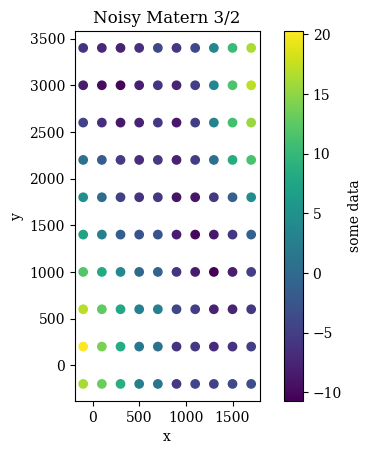

In [3]:
plt.figure()
plt.scatter(Xg, Yg, c=zg)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Noisy Matern 3/2')
plt.colorbar(label='some data')
plt.gca().set_aspect('equal')

## Inference

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


In [4]:
from gptide import mcmc
n = len(xd)
covparams

(10, 900, 1800)

In [5]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(0.4, 0.25, 1e-15, 1)           # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(8, 3, 2, 14),                   # eta   - true value 10
                    gpstats.truncnorm(600, 200, 1e-15, 1e4),           # ℓ_x - true value 900
                    gpstats.truncnorm(1400, 250, 1e-15, 1e4)           # ℓ_y - true value 1800
                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( X, 
                                                    zd, 
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=30,
                                                    niter=100,
                                                    verbose=False)



Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.67it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


## Find sample with highest log prob

In [6]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_x (true):   {:3.2f},  ℓ_x   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('ℓ_y (true):   {:3.2f},  ℓ_y   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 


Noise (true): 0.50,  Noise (mcmc): 0.31
η   (true):   10.00,  η     (mcmc): 7.83
ℓ_x (true):   900.00,  ℓ_x   (mcmc): 667.02
ℓ_y (true):   1800.00,  ℓ_y   (mcmc): 1777.49


In [7]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f},  Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('ℓ_x (true):   {:3.2f},  ℓ_x   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
print('ℓ_y (true):   {:3.2f},  ℓ_y   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 


Noise (true): 0.50,  Noise (mcmc): 0.31
η   (true):   10.00,  η     (mcmc): 7.83
ℓ_x (true):   900.00,  ℓ_x   (mcmc): 667.02
ℓ_y (true):   1800.00,  ℓ_y   (mcmc): 1777.49


## Posterior density plot

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from current font.
  func(*args, **kwargs)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


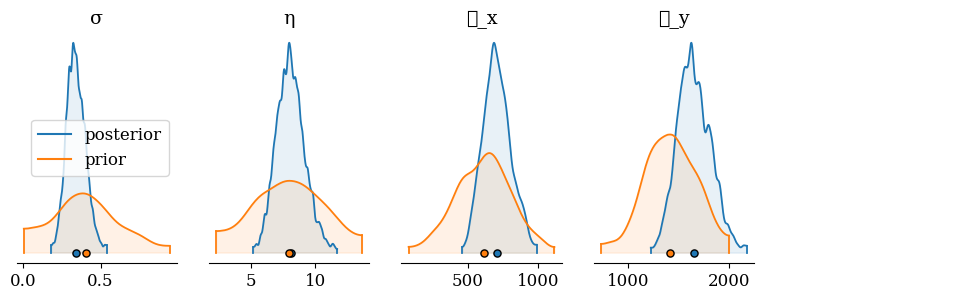

In [8]:
labels = ['σ','η','ℓ_x', 'ℓ_y']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)


## Posterior corner plot

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from current font.
  func(*args, **kwargs)
Font 'default' does not have a glyph for '\u2113' [U+2113], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2113' [U+2113], substituting with a dummy symbol.
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
Font 'default' does not have a glyph for '\u2113' [U+2113], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2113' [U+2113], substituting with a dummy symbol.


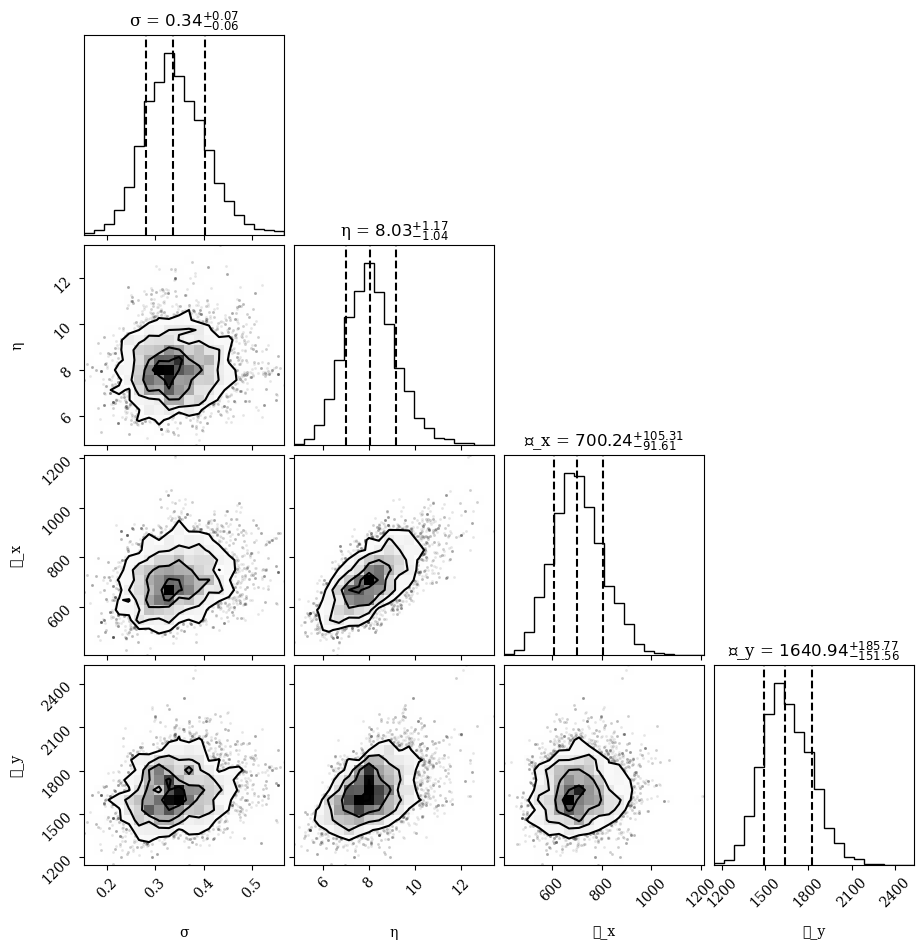

In [9]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

## Condition and make predictions

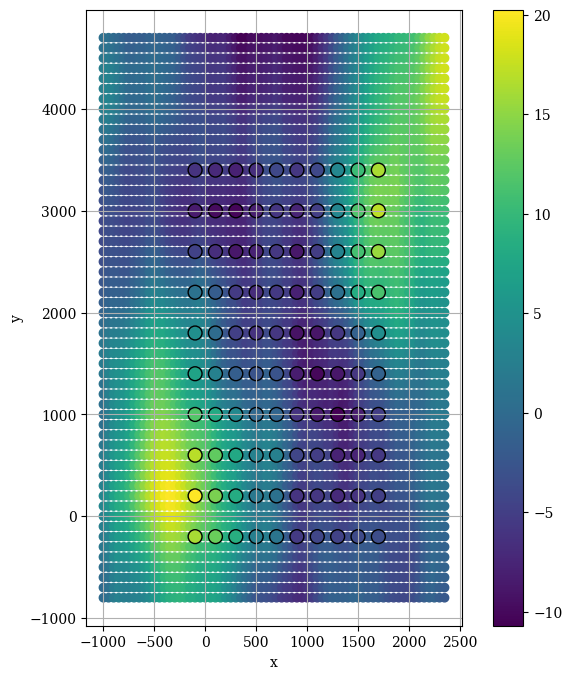

In [10]:
plt.figure(figsize=(8, 8))
plt.ylabel('y')
plt.xlabel('x')

# xo = np.arange(0,dx*N,dx/3)[:,None]
xdo = np.arange(-dx*0.5*N, dx*1.2*N, dx/4)[:,None]
ydo = np.arange(-dy*0.2*N, dy*1.2*N, dy/4)[:,None]

# Make a grid
Xgo, Ygo = np.meshgrid(xdo, ydo)

# Vectorise grid and stack
Xvo = Xgo.ravel()
Yvo = Ygo.ravel()
Xo = np.hstack([Xvo[:,None], Yvo[:,None]])
    
OI = GPtideScipy(X, Xo, 0, covfunc, MAP[1:], 
             P=1, mean_func=None)
out_map = OI.conditional(zd)

plt.scatter(Xgo, Ygo, c=out_map, alpha=1)
plt.scatter(Xg, Yg,   c=zg, s=100, edgecolors='k')

plt.grid()
plt.gca().set_aspect('equal')
plt.colorbar()

In [11]:
Xo.shape

(3808, 2)

In [12]:
zd.shape

(100, 1)

In [13]:
OI.Kmd.shape

(3808, 100)